In [112]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import joblib


In [113]:
# Load datasets
train_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/new_train_data.csv")
test_df = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/new_test_data.csv")

In [114]:
# Drop unnecessary columns (Clothing ID - not useful for prediction)
train_df.drop(columns=["Clothing ID"], inplace=True)
test_df.drop(columns=["Clothing ID"], inplace=True)

In [115]:
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
train_df["Title"] = train_df["Title"].fillna("")
train_df["Review Text"] = train_df["Review Text"].fillna("")
test_df["Title"]=test_df["Title"].fillna("")
test_df["Review Text"]= test_df["Review Text"].fillna("")

In [116]:
# Encode categorical features
label_encoders = {}
categorical_cols = ["Division Name", "Department Name", "Class Name"]

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    
    # Handle unseen categories in test set
    test_df[col] = test_df[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    label_encoders[col] = le

In [117]:
# Convert text data into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
train_tfidf = tfidf_vectorizer.fit_transform(train_df["Review Text"] + " " + train_df["Title"])
test_tfidf = tfidf_vectorizer.transform(test_df["Review Text"] + " " + test_df["Title"])


In [118]:

# Define features and target
X_train = hstack((train_tfidf, train_df.drop(columns=["Review Text", "Title", "Rating"]))) # , "Recommended IND"
y_train = train_df["Rating"]
X_test = hstack((test_tfidf, test_df.drop(columns=["Review Text", "Title", "Rating"])))
y_test = test_df["Rating"]

In [119]:

# Train LightGBM Model with Hyperparameter Tuning
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20]
}

In [ ]:
# ############## remapling to deal with imbalanced dataset biased results ##########################
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Train the LightGBM model on balanced data
# lgb_clf = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
# lgb_clf.set_params(max_bin=63)  # Setting max_bin to 255
# lgb_clf.set_params(num_leaves = 50)
# lgb_clf.set_params(learning_rate = 0.05)
# lgb_clf.set_params(n_estimators= 500)
# lgb_clf.set_params(max_depth=-1)

# #grid_search = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# #grid_search.fit(X_train_resampled, X_train_resampled)
# lgb_clf.fit(X_train_resampled, y_train_resampled)

# # Best model
# #best_lgb = grid_search.best_estimator_


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35722
[LightGBM] [Info] Number of data points in the train set: 8420, number of used features: 1006
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_bin=63,
               n_estimators=500, num_leaves=50, random_state=42)

In [121]:
# Base Model
# Convert to DataFrame with feature names
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test_df = pd.DataFrame(X_test.toarray(), columns=feature_names)

# defines the model:
lgb_clf = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

########### we can do the grid search OR manual seting the parameters ##############################

########### the grid search ############################## Slow
# lgb_clf.set_params(max_bin=63)  # the deault value: 255 -- reduced to improve memory usage
grid_search = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_df, y_train)
print("Best Model Parameters:", grid_search.best_params_)
# # fits the Best model
best_lgb = grid_search.best_estimator_

#### or ####
########### manual seting the parameters ############################## Fast
# #to skip grid search we can run this section instead: 
# #lgb_clf.set_params(max_bin=63)  # Setting max_bin to 255
# lgb_clf.set_params(num_leaves = 100)
# lgb_clf.set_params(learning_rate = 0.05)
# lgb_clf.set_params(n_estimators= 500)
# lgb_clf.set_params(max_depth=-1)


# lgb_clf.fit(X_train_df, y_train)




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43956
[LightGBM] [Info] Number of data points in the train set: 6978, number of used features: 1004
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [130]:
print("Best Model Parameters:", grid_search.best_params_)

Best Model Parameters: {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 100}


In [131]:
# Predictions & Evaluation
y_pred = best_lgb.predict(X_test_df)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(class_report)

print(f"Final Accuracy: {accuracy:.4f}")



Classification Report:

              precision    recall  f1-score   support

           1       0.24      0.40      0.30       168
           2       0.22      0.46      0.29       313
           3       0.32      0.28      0.30      1187
           4       0.35      0.56      0.43      3393
           5       0.87      0.69      0.77     11447

    accuracy                           0.63     16508
   macro avg       0.40      0.48      0.42     16508
weighted avg       0.70      0.63      0.65     16508

Final Accuracy: 0.6273


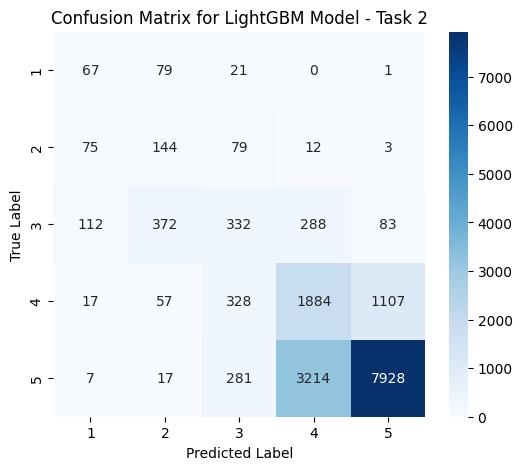

In [124]:
plt.figure(figsize=(6, 5))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for LightGBM Model - Task 2")
plt.show()

In [125]:
joblib.dump(best_lgb, "lightgbm_task2_model.pkl")
print("Model saved successfully as lightgbm_task2_model.pkl")

Model saved successfully as lightgbm_task2_model.pkl


In [126]:
loaded_model = joblib.load("lightgbm_task2_model.pkl")
print("Model loaded successfully.")

Model loaded successfully.


In [127]:
############## Predtcion Function: Loads the saved model and does the prediction for new records ##############################

def predict_future(data):
    loaded_model = joblib.load("lightgbm_task2_model.pkl")
    data.drop(columns=["Clothing ID"], inplace=True)

    ##########        Preprocessing: 3 mandatory and 1 optional step      ######################
    ##### 1 Handle missing values
    imputer = SimpleImputer(strategy='most_frequent')
    data["Title"] = data["Title"].fillna("")
    data["Review Text"] = data["Review Text"].fillna("")
    
    ##### 2 Encoding the categorical features: 
    # Ensure categorical columns are encoded the same way as in training
    for col in ["Division Name", "Department Name", "Class Name"]:
        if col in data.columns:
            data[col] = data[col].astype(str).map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

    ##### 3 tokenizing the textual features:
    data_tfidf = tfidf_vectorizer.transform(data["Review Text"] + " " + data["Title"])
    data_prediction = hstack((data_tfidf, data.drop(columns=["Review Text", "Title","Rating"])))

    #### 4 - Optional (preventing a warning): Convert to DataFrame with feature names
    feature_names = [f"feature_{i}" for i in range(data_prediction.shape[1])]
    X_data_prediction = pd.DataFrame(data_prediction.toarray(), columns=feature_names)

    ##########      perform the Precition by the saved model and preprocessed new records       ################################
    predictions = loaded_model.predict(X_data_prediction) 
    return predictions

In [128]:
data = pd.read_csv("C:/GitHub/Machine-Learning/INF1279H/new_data_model_test.csv")
#print(data)
pred = predict_future(data)
print("Here is the predicted rating for new record(s):", pred)


Here is the predicted rating for new record(s): [4]


In [129]:
print(pred)

[4]
